# Example3_MultiSetupPreGER

In [1]:
import os
import sys
# Add the directory we executed the script from to path:
sys.path.insert(0, os.path.realpath('__file__'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyoma2.algorithm import SSIdat_algo_MS, pLSCF_algo_MS
from pyoma2.OMA import MultiSetup_PreGER

For the preGER merging procedure, we adopt a strategy similar to that used for the single setup class. The first step involves instantiating the **MultiSetup_PreGER** class and passing the list of datasets, the lists of reference sensors, and their sampling frequency. Similarly to the single setup class, also for the preGER class we can detrend and/or decimate the signals with the **detrend_data()** and **decimate_data()** methods. Furthermore, we can plot all the time histories of the channels for the selected datasets calling the **plot_data()** method, and get more info from each channel from the selected datasets calling the **plot_ch_info()** method.

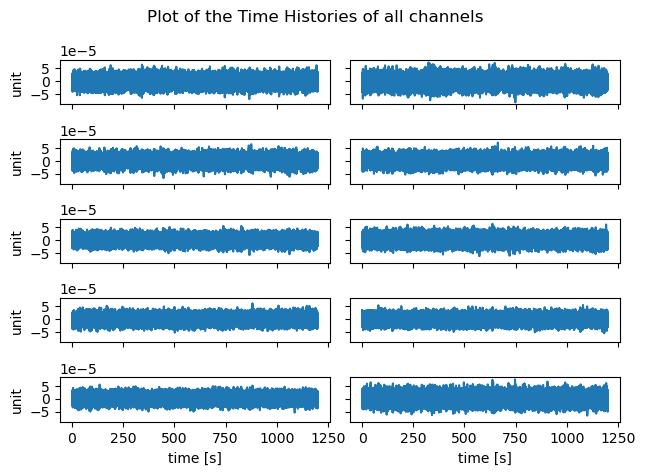

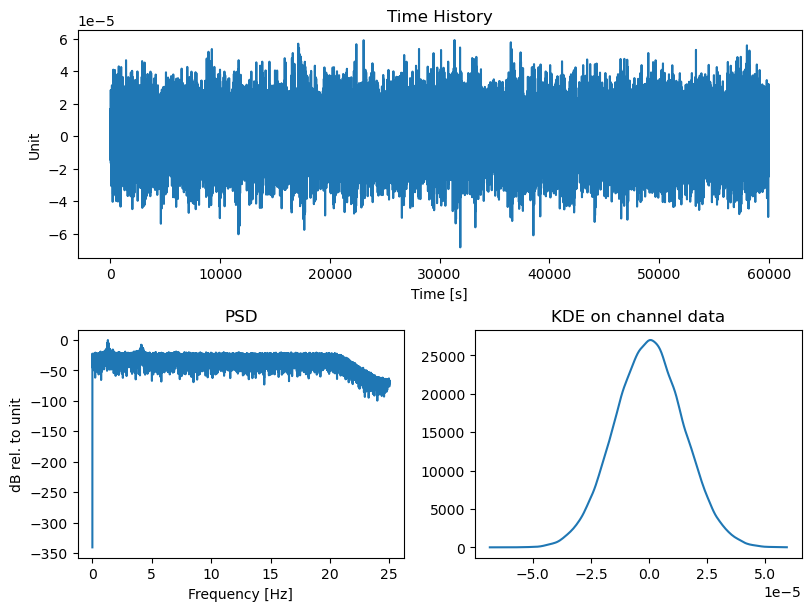

In [2]:
# import data files
set1 = np.load("../src/pyoma2/test_data/3SL/set1.npy", allow_pickle=True)
set2 = np.load("../src/pyoma2/test_data/3SL/set2.npy", allow_pickle=True)
set3 = np.load("../src/pyoma2/test_data/3SL/set3.npy", allow_pickle=True)

# list of datasets and reference indices
data = [set1, set2, set3]
ref_ind = [[0, 1, 2], [0, 1, 2], [0, 1, 2]]

# Create multisetup
msp = MultiSetup_PreGER(fs=100, ref_ind=ref_ind, datasets=data)

# decimate data
msp.decimate_data(q=2)

# plot Time Histories of all channels for the selected datasets
fig, ax = msp.plot_data(data_idx=[2], nc=2)

# Plot TH, PSD and KDE of the (selected) channels of the (selected) datasets
figs, axs = msp.plot_ch_info(data_idx=[1], ch_idx=[2])

Again if we want to be able to plot the mode shapes later, then we need to define the geometry of the structure. 

In [3]:
# import geometry files
# Names of the channels
Names = [
    ["ch1_1","ch2_1","ch3_1","ch4_1","ch5_1","ch6_1","ch7_1","ch8_1","ch9_1","ch10_1"],
    ["ch1_2","ch2_2","ch3_2","ch4_2","ch5_2","ch6_2","ch7_2","ch8_2","ch9_2","ch10_2"],
    ["ch1_3","ch2_3","ch3_3","ch4_3","ch5_3","ch6_3","ch7_3","ch8_3","ch9_3","ch10_3"]]
# Background
BG_nodes = np.loadtxt("../src/pyoma2/test_data/3SL/BG_nodes.txt")
BG_lines = np.loadtxt("../src/pyoma2/test_data/3SL/BG_lines.txt").astype(int)
# Geometry 1
sens_coord = pd.read_csv("../src/pyoma2/test_data/3SL/sens_coord.txt", sep="\t")
sens_dir = np.loadtxt("../src/pyoma2/test_data/3SL/sens_dir.txt")
# Geometry 2
sens_lines = np.loadtxt("../src/pyoma2/test_data/3SL/sens_lines.txt").astype(int)
pts_coord = pd.read_csv("../src/pyoma2/test_data/3SL/pts_coord.txt", sep="\t")
sens_map = pd.read_csv("../src/pyoma2/test_data/3SL/sens_map.txt", sep="\t")
sens_sign = pd.read_csv("../src/pyoma2/test_data/3SL/sens_sign.txt", sep="\t")

# Define geometry1
msp.def_geo1(
    Names,  # Names of the channels
    sens_coord,  # coordinates of the sensors
    sens_dir,  # sensors' direction
    bg_nodes=BG_nodes,  # BG nodes
    bg_lines=BG_lines,) # BG lines

# Define geometry 2
msp.def_geo2(
    Names,  # Names of the channels
    pts_coord,
    sens_map,
    order_red="xy",
    sens_sign=sens_sign,
    sens_lines=sens_lines,
    bg_nodes=BG_nodes,
    bg_lines=BG_lines)

Now we need to instantiate the multi-setup versions of the algorithms we wish to execute, such as SSIdat_algo.

2024-02-23 14:50:52,171 - pyoma2.OMA - INFO - Running SSIdat... (OMA:148)
100%|████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 9000.89it/s]
2024-02-23 14:51:00,195 - pyoma2.OMA - INFO - Running pLSCF... (OMA:148)
100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [01:06<00:00,  1.21it/s]
2024-02-23 14:52:10,068 - pyoma2.OMA - INFO - all done (OMA:127)


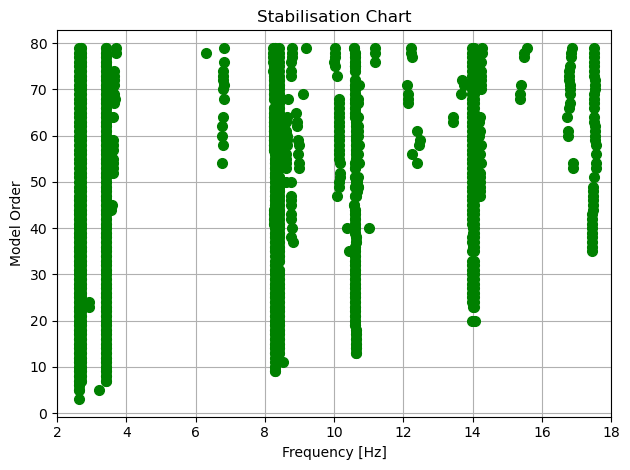

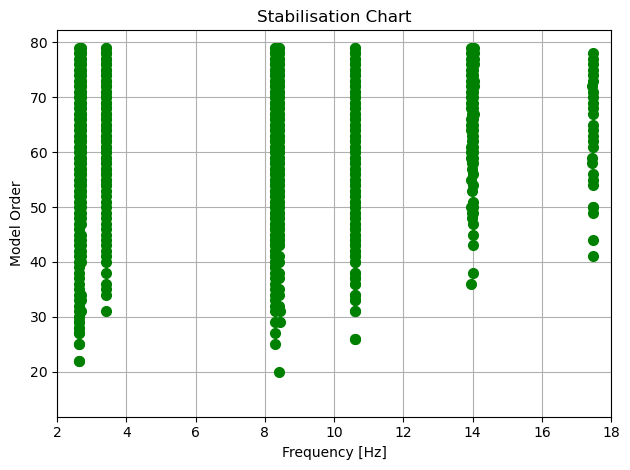

In [4]:
# Initialise the algorithms
ssidat = SSIdat_algo_MS(name="SSIdat", br=80, ordmax=80)
plscf = pLSCF_algo_MS(name="pLSCF", ordmax=80, nxseg=1024)

# Add algorithms to the class
msp.add_algorithms(ssidat,plscf)
msp.run_all()

# Plot
fig1, ax1 = ssidat.plot_STDiag(freqlim=(2,18))
fig2, ax2 = plscf.plot_STDiag(freqlim=(2,18))

After the algorithms have been executed we can exctract the desired poles and plot the mode shapes.

2024-02-23 14:52:10,731 - pyoma2.OMA - INFO - Getting MPE modal parameters from SSIdat (OMA:173)
2024-02-23 14:52:10,732 - pyoma2.functions.SSI_funct - INFO - Extracting SSI modal parameters (SSI_funct:632)
100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3604.39it/s]
2024-02-23 14:52:10,741 - pyoma2.OMA - INFO - Getting MPE modal parameters from pLSCF (OMA:173)
2024-02-23 14:52:10,742 - pyoma2.functions.pLSCF_funct - INFO - Extracting SSI modal parameters (pLSCF_funct:261)
100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3047.69it/s]


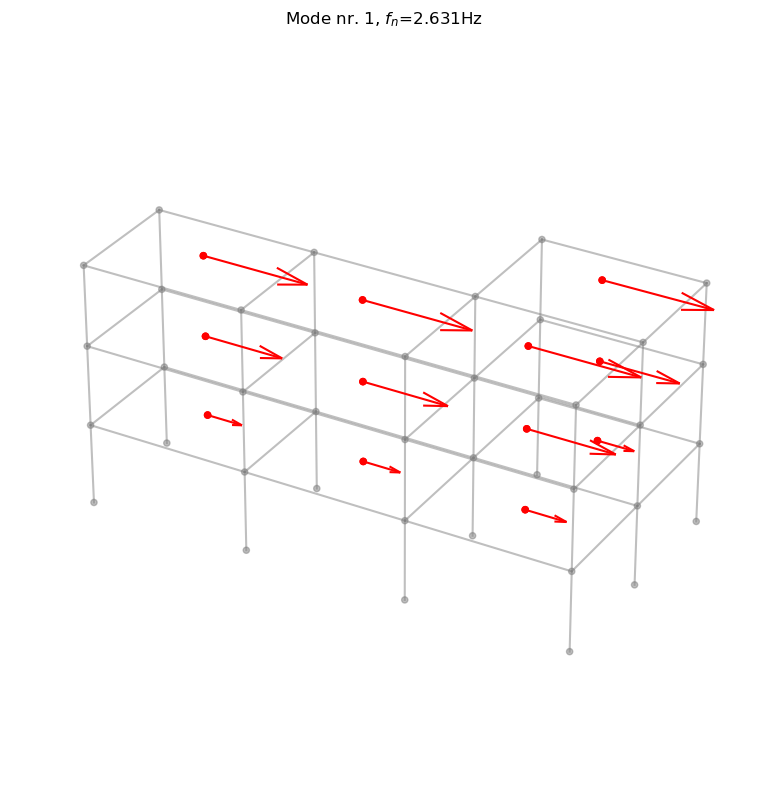

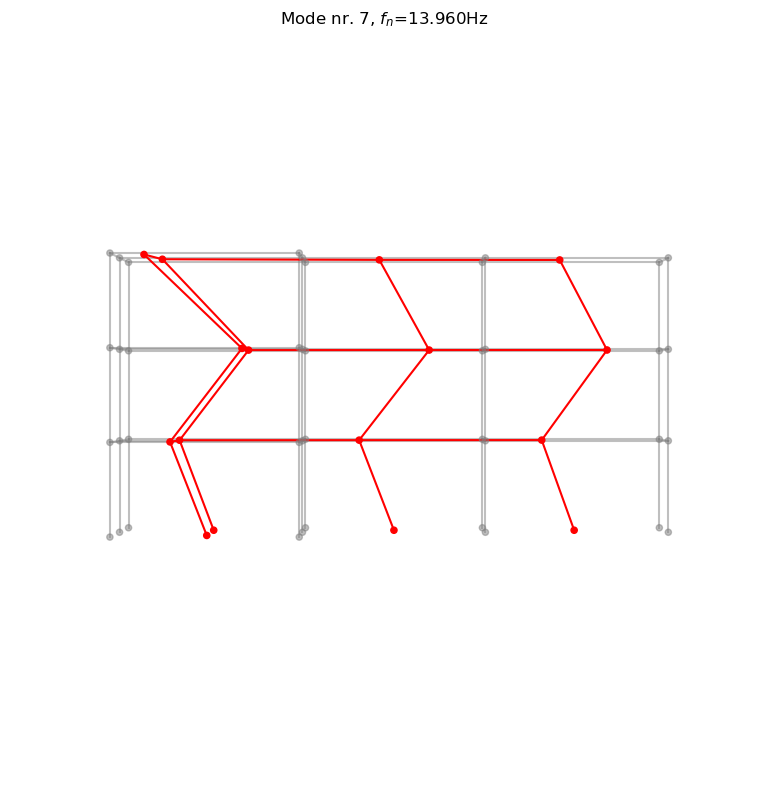

In [5]:
# get modal parameters
msp.MPE(
    "SSIdat",
    sel_freq=[2.63, 2.69, 3.43, 8.29, 8.42, 10.62, 14.00, 14.09, 17.57],
    order=80)

msp.MPE(
    "pLSCF",
    sel_freq=[2.63, 2.69, 3.43, 8.29, 8.42, 10.62, 13.95, 14.09, 17.57],
    order=70)

# plot mode shapes
fig3, ax3 = ssidat.plot_mode_g1(Geo1=msp.Geo1, mode_numb=1, view="3D", scaleF=2)
fig4, ax4 = plscf.plot_mode_g2(Geo2=msp.Geo2, mode_numb=7, view="xz", scaleF=2)

In [6]:
ssidat.result.Fn

array([ 2.63102473,  2.69617968,  3.42605687,  8.27997956,  8.41882261,
       10.59171709, 13.96998337, 14.03397164, 17.49790384])

In [7]:
plscf.result.Fn

array([ 2.63102973,  2.69280784,  3.42568084,  8.28795249,  8.41589269,
       10.60107002, 13.95961586, 14.02220145, 17.46686033])